In [0]:
import pandas as pd
import numpy as np
import gc
import zipfile
import pip
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import linear_model
from yellowbrick.classifier import ClassificationReport
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score

In [0]:
# reading in the train and testing data
train = pd.read_csv('train.csv')

ParserError: ignored

In [0]:
train.dropna(inplace=True)
train.shape

(53565, 68)

### Co-Linearity

In [0]:
cols = train.columns.tolist()

# columns to remove
corr_remove = []

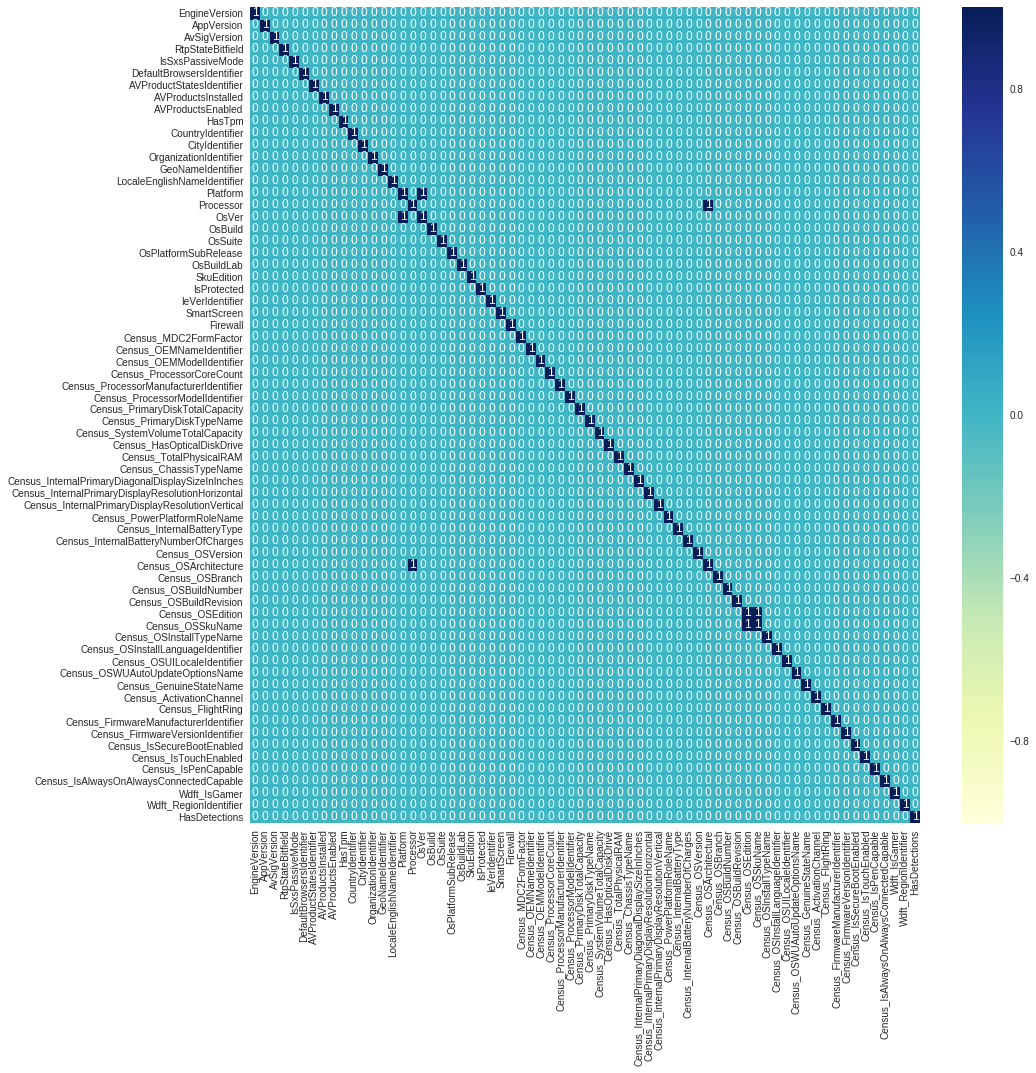

In [0]:
corr = train.corr()
high_corr = (corr >= 0.99).astype('uint8')
plt.figure(figsize=(15,15))
sns.heatmap(high_corr, cmap='YlGnBu', annot=True, center=0.0)
plt.show()

In [0]:
print('Census_OSArchitecture Unique Values:', train.Census_OSArchitecture.nunique())
print('Processor Unique Values:', train.Processor.nunique())

Census_OSArchitecture Unique Values: 3
Processor Unique Values: 3


In [0]:
corr_remove.append('Census_OSArchitecture')

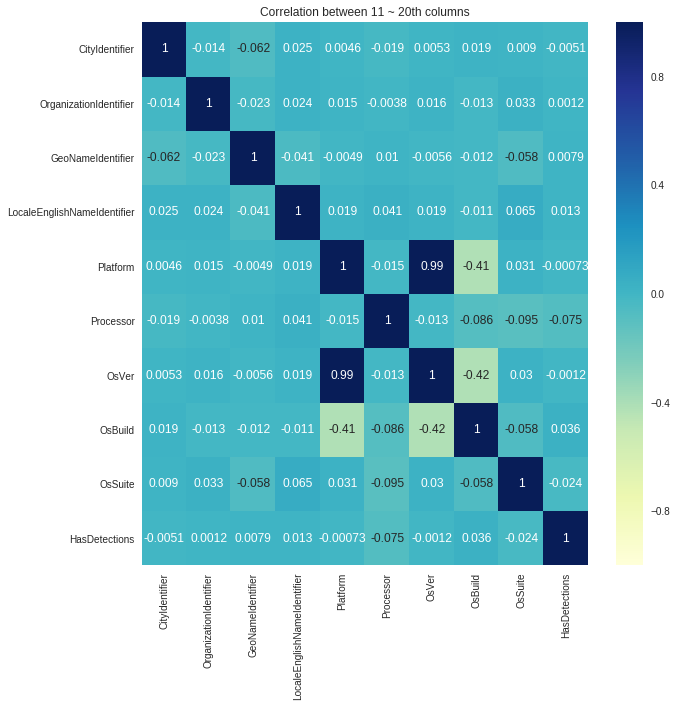

In [0]:
co_cols = cols[11:20]
co_cols.append('HasDetections')
plt.figure(figsize=(10,10))
sns.heatmap(train[co_cols].corr(), cmap='YlGnBu', annot=True, center=0.0)
plt.title('Correlation between 11 ~ 20th columns')
plt.show()

In [0]:
print('Platform Unique Values:', train.Platform.nunique())
print('OsVer Unique Value:', train.OsVer.nunique())

Platform Unique Values: 3
OsVer Unique Value: 7


In [0]:
corr_remove.append('Platform')

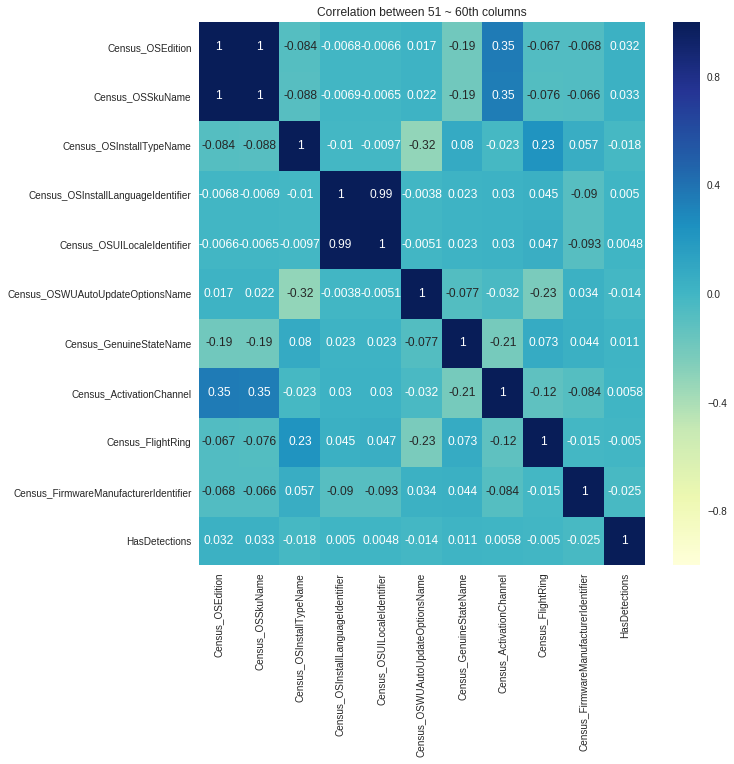

In [0]:
co_cols = cols[50:60]
co_cols.append('HasDetections')
plt.figure(figsize=(10,10))
sns.heatmap(train[co_cols].corr(), cmap='YlGnBu', annot=True, center=0.0)
plt.title('Correlation between 51 ~ 60th columns')
plt.show()

In [0]:
print('Census_OSSkuName Unique Values:', train.Census_OSSkuName.nunique())
print('Census_OSEdition Unique Values:', train.Census_OSEdition.nunique())
print()
print('Census_OSInstallLanguageIdentifier Unique Values:', train.Census_OSInstallLanguageIdentifier.nunique())
print('Census_OSUILocaleIdentifier Unique Values:', train.Census_OSUILocaleIdentifier.nunique())

Census_OSSkuName Unique Values: 13
Census_OSEdition Unique Values: 15

Census_OSInstallLanguageIdentifier Unique Values: 39
Census_OSUILocaleIdentifier Unique Values: 58


In [0]:
corr_remove.append('Census_OSSkuName')
corr_remove.append('Census_OSInstallLanguageIdentifier')

In [0]:
train.drop(corr_remove, axis=1, inplace=True)

In [0]:
train.shape

### Exploring Data

In [0]:
detect_no = (train["HasDetections"]==0).sum()
detect_yes = (train["HasDetections"]==1).sum()

labels = 'No Detection', 'Detection',
sizes = [detect_no, detect_yes]

In [0]:
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=False, startangle=90, textprops={'fontsize': 15})
ax1.axis('equal')

plt.show()

### Splitting Data

In [0]:
# splitting by features and labels
y_train = train['HasDetections']
X_train = train.drop(columns=['HasDetections'])

In [0]:
# splitting training data into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size = 0.30, random_state = 10)

### Methods for Metrics 

In [0]:
def conf_mat(y_test, y_pred): return confusion_matrix(y_test, y_pred)

def tn(y_test, y_pred): return conf_mat(y_test, y_pred)[0, 0]
def tp(y_test, y_pred): return conf_mat(y_test, y_pred)[1, 1]
def fp(y_test, y_pred): return conf_mat(y_test, y_pred)[0, 1]
def fn(y_test, y_pred): return conf_mat(y_test, y_pred)[1, 0]

# accuracy
def accuracy(y_test, y_pred): return (tp(y_test, y_pred) + tn(y_test, y_pred)) / len(y_pred)

# error
def error(y, x, model): return np.mean((y - model.predict(x)) ** 2)

# percision
def precision(y_test, y_pred): return tp(y_test, y_pred) / (tp(y_test, y_pred) + fp(y_test, y_pred))

# recall
def recall(y_test, y_pred): return tp(y_test, y_pred) / (tp(y_test, y_pred) + fn(y_test, y_pred))

# f1
def f1(y_test, y_pred): return 2 * (precision(y_test, y_pred) * recall(y_test, y_pred)) / (precision(y_test, y_pred) + recall(y_test, y_pred))

In [0]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

## Models

### Logistic Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Precent Correct: 52.45%, Error: 0.4755
AUROC Logistic Regression = 0.5369202893515795


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


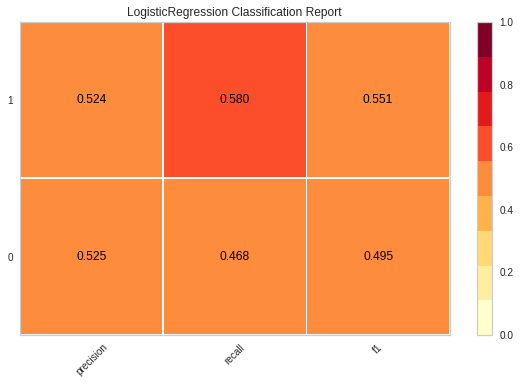

In [0]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_valid)
print('Precent Correct: {:.2%}, Error: {:.4f}'.format(accuracy(y_valid, y_pred), 1 - accuracy(y_valid, y_pred)))

print("AUROC Logistic Regression = {}".format(roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1])))

# classification model and visualizer
visualizer = ClassificationReport(logreg, classes=['0','1'])

visualizer.fit(X_train, y_train)  # Fitting the training data to the visualizer
visualizer.score(X_valid, y_valid)  # Evaluating the model on the validation data
g = visualizer.poof()             # results

#The low accuracy, precision, recall, and F1 score for logistic regression leads me to believe that my data is not linearly seperable

In [0]:
# calculating the accuracy of the model
y_scores = logreg.predict_proba(X_valid)
fpr, tpr, threshold = roc_curve(y_valid, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

# plotting roc curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.show()

In [0]:
cm = confusion_matrix(y_valid, y_pred)
print_cm(cm, ['No Detection', 'Detection'])

### Logistic Regression with Lasso

In [0]:
logreg_lasso = LogisticRegression(penalty='l1')
logreg_lasso.fit(X_train, y_train)

y_pred_lasso = logreg_lasso.predict(X_valid)
#print('Precent Correct: {:.2%}, Error: {:.4f}'.format(accuracy(y_valid, y_pred_lasso), 1 - accuracy(y_valid, y_pred_lasso)))

#print("AUROC Logistic Regression with Lasso = {}".format(roc_auc_score(y_train, logreg_lasso.predict_proba(X_train)[:,1])))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
cm = confusion_matrix(y_valid, y_pred_lasso)
print_cm(cm, ['No Detection', 'Detection'])

visualizer = ClassificationReport(logreg_lasso, classes=['0','1'])

visualizer.fit(X_train, y_train)  
visualizer.score(X_valid, y_valid)  
g = visualizer.poof()             

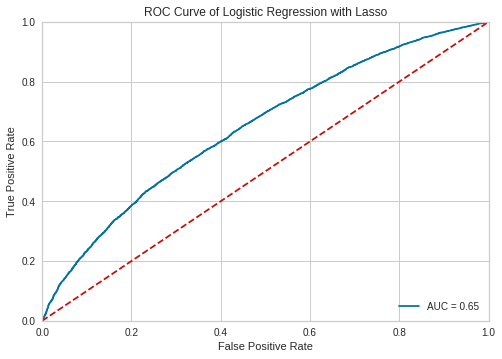

In [0]:
# calculating the accuracy of the model
y_scores = logreg_lasso.predict_proba(X_valid)
fpr, tpr, threshold = roc_curve(y_valid, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

# plotting roc curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression with Lasso')
plt.show()

### LDA

In [0]:
# sensative to outliars
# works well with Gaussian distributions

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# predicting the response
pred_lda = lda.predict(X_valid)

# evaluating accuracy
print('Precent Correct: {:.2%}, Error: {:.4f}'.format(accuracy(y_valid, pred_lda), 1 - accuracy(y_valid, pred_lda)))

print("AUROC LDA = {}".format(roc_auc_score(y_train, lda.predict_proba(X_train)[:,1])))

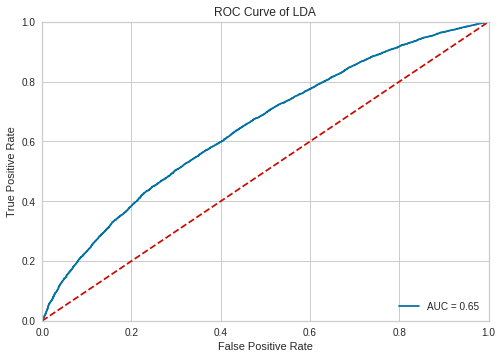

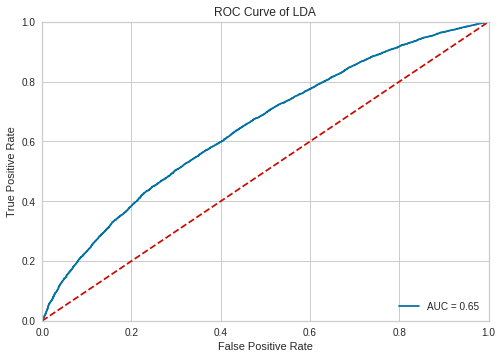

In [0]:
# calculating the accuracy of the model
y_scores = lda.predict_proba(X_valid)
fpr, tpr, threshold = roc_curve(y_valid, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

# plotting roc curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of LDA')
plt.show()

         t/p     No Detection    Detection 
    No Detection     114681.0      90466.0 
       Detection      71956.0     133907.0 


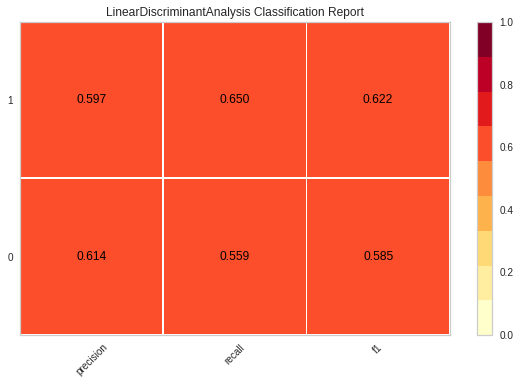

In [0]:
cm = confusion_matrix(y_valid, pred_lda)
print_cm(cm, ['No Detection', 'Detection'])

visualizer = ClassificationReport(lda, classes=['0','1'])

visualizer.fit(X_train, y_train)  
visualizer.score(X_valid, y_valid)  
g = visualizer.poof()             

### Adaboost

In [0]:
ada = AdaBoostClassifier(n_estimators = 50)
ada.fit(X_train, y_train)

# predict the response
pred_ada = ada.predict(X_valid)

print('Precent Correct: {:.2%}, Error: {:.4f}'.format(accuracy(y_valid, pred_ada), 1 - accuracy(y_valid, pred_ada)))

Precent Correct: 62.65%, Error: 0.3735


         t/p     No Detection    Detection 
    No Detection     124356.0      80791.0 
       Detection      68836.0     137027.0 


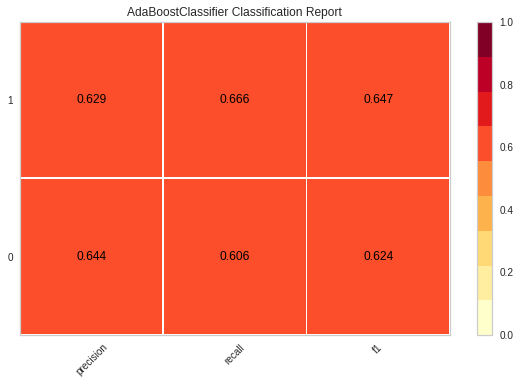

In [0]:
cm = confusion_matrix(y_valid, pred_ada)
print_cm(cm, ['No Detection', 'Detection'])

visualizer = ClassificationReport(ada, classes=['0','1'])

visualizer.fit(X_train, y_train)  
visualizer.score(X_valid, y_valid)  
g = visualizer.poof()             

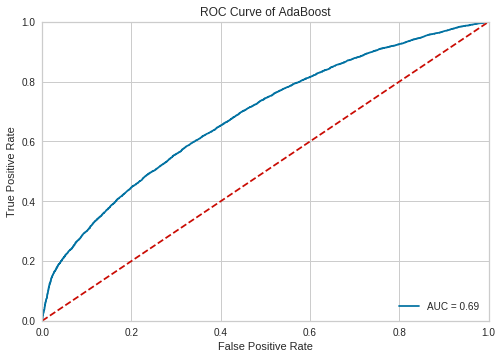

In [0]:
# calculating the accuracy of the model
y_scores = ada.predict_proba(X_valid)
fpr, tpr, threshold = roc_curve(y_valid, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

# plotting roc curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of AdaBoost')
plt.show()

### Random Forest

In [0]:
rf = RandomForestClassifier(n_estimators = 50)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_valid)
print('Precent Correct: {:.2%}, Error: {:.4f}'.format(accuracy(y_valid, pred_rf), 1 - accuracy(y_valid, pred_rf)))

Precent Correct: 62.36%, Error: 0.3764


         t/p     No Detection    Detection 
    No Detection     137830.0      67317.0 
       Detection      79478.0     126385.0 


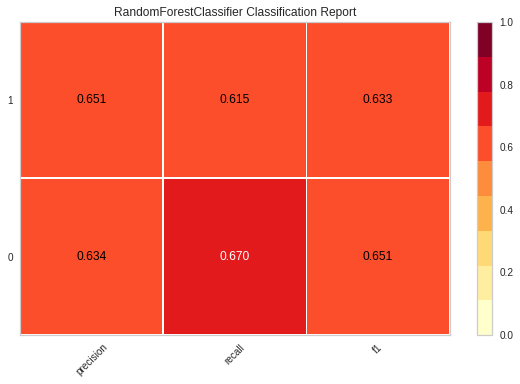

In [0]:
cm = confusion_matrix(y_valid, pred_rf)
print_cm(cm, ['No Detection', 'Detection'])

visualizer = ClassificationReport(rf, classes=['0','1'])

visualizer.fit(X_train, y_train)  
visualizer.score(X_valid, y_valid)  
g = visualizer.poof()             

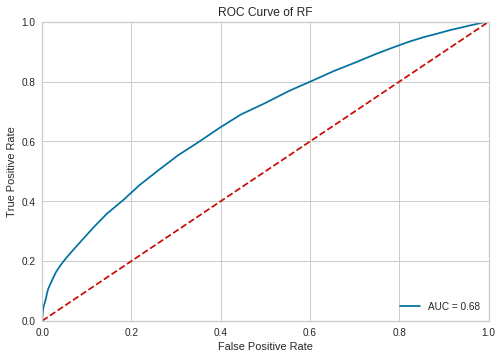

In [0]:
# calculating the accuracy of the model
y_scores = rf.predict_proba(X_valid)
fpr, tpr, threshold = roc_curve(y_valid, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

# plotting roc curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of RF')
plt.show()

### Feature Importance From Random Forest

In [0]:
feature_impotance = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_}).sort_values(by='importance', ascending=False)
feature_impotance = feature_impotance.reset_index()
feature_impotance.head(15)

,index,feature,importance
0,2,AvSigVersion,0.063320
1,24,SmartScreen,0.054253
2,11,CityIdentifier,0.054217
3,34,Census_SystemVolumeTotalCapacity,0.052960
4,56,Census_FirmwareVersionIdentifier,0.050061
5,28,Census_OEMModelIdentifier,0.045842
6,31,Census_ProcessorModelIdentifier,0.043968
7,10,CountryIdentifier,0.036869
8,13,GeoNameIdentifier,0.031145
9,14,LocaleEnglishNameIdentifier,0.030794


In [0]:
# removing unimportant features 
to_keep = feature_impotance.loc[feature_impotance['importance']>0.005, 'feature']
len(to_keep)

X_keep = X_train.copy()[to_keep]
X_keep.sample(5)

,AvSigVersion,SmartScreen,CityIdentifier,Census_SystemVolumeTotalCapacity,Census_FirmwareVersionIdentifier,Census_OEMModelIdentifier,Census_ProcessorModelIdentifier,CountryIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,...,Census_OSEdition,IeVerIdentifier,Census_ProcessorCoreCount,Census_ActivationChannel,Census_InternalBatteryType,Wdft_IsGamer,Census_MDC2FormFactor,Census_PrimaryDiskTypeName,Census_OSBranch,Census_IsSecureBootEnabled
845606,8275,7,70599.0,705623.0,16931.0,35153.0,2320.0,160,204.0,170,...,2.0,137.0,4.0,2.0,68.0,1.0,8,0,9.0,0.0
417220,8380,7,130775.0,476324.0,26159.0,171142.0,1992.0,41,143.0,226,...,5.0,137.0,2.0,0.0,68.0,0.0,8,0,9.0,1.0
852853,7906,7,124736.0,476324.0,33166.0,244755.0,37.0,171,211.0,182,...,5.0,137.0,4.0,2.0,68.0,0.0,8,0,9.0,0.0
721730,8471,7,18706.0,113857.0,64956.0,263610.0,2962.0,164,205.0,172,...,16.0,137.0,8.0,2.0,68.0,0.0,2,1,9.0,0.0
548251,7990,7,155216.0,237906.0,3844.0,313586.0,2892.0,11,16.0,102,...,2.0,137.0,8.0,2.0,68.0,1.0,2,1,9.0,0.0


In [0]:
# splitting training data into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(
    X_keep, y_train, test_size = 0.30, random_state = 10)

In [0]:
rf = RandomForestClassifier(n_estimators = 50)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_valid)
print('Precent Correct: {:.2%}, Error: {:.4f}'.format(accuracy(y_valid, pred_rf), 1 - accuracy(y_valid, pred_rf)))

Precent Correct: 63.70%, Error: 0.3630
